The aim of this project is to test the short and long run relationship between GDP and unemployment in South Africa. We expect a negative relationship between these variables, with a 4% increase in GDP leading to a decrease in unemployment rate by 1% according to Okun's law. An OLS model and a Vector Error Correction Model will be used to evaluate the relationship.

The data examined is quarterly data from 1995:Q1 to 2019:Q4.

This data was obtained from the South Africa Reserve Bank website: https://www.resbank.co.za

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.vector_ar import vecm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
sns.set_theme()

In [2]:
# Importing the data
parser = lambda x: pd.to_datetime(x, format="%Y-%m-%d")
df = pd.read_csv('data/Final.csv',date_parser=parser,parse_dates=['Date'])
df['LGDP'] = df['GDP'].apply(lambda x: np.log(x))
df.head()

,Date,GDP,UnRate,GDPgrowth,LGDP
0,1995-01-01,1692669,16.9,1.444820,14.341817
1,1995-04-01,1700185,16.9,1.776130,14.346248
2,1995-07-01,1707524,16.9,1.726636,14.350555
3,1995-10-01,1714263,16.9,1.578660,14.354494
4,1996-01-01,1738318,19.3,5.612908,14.368429


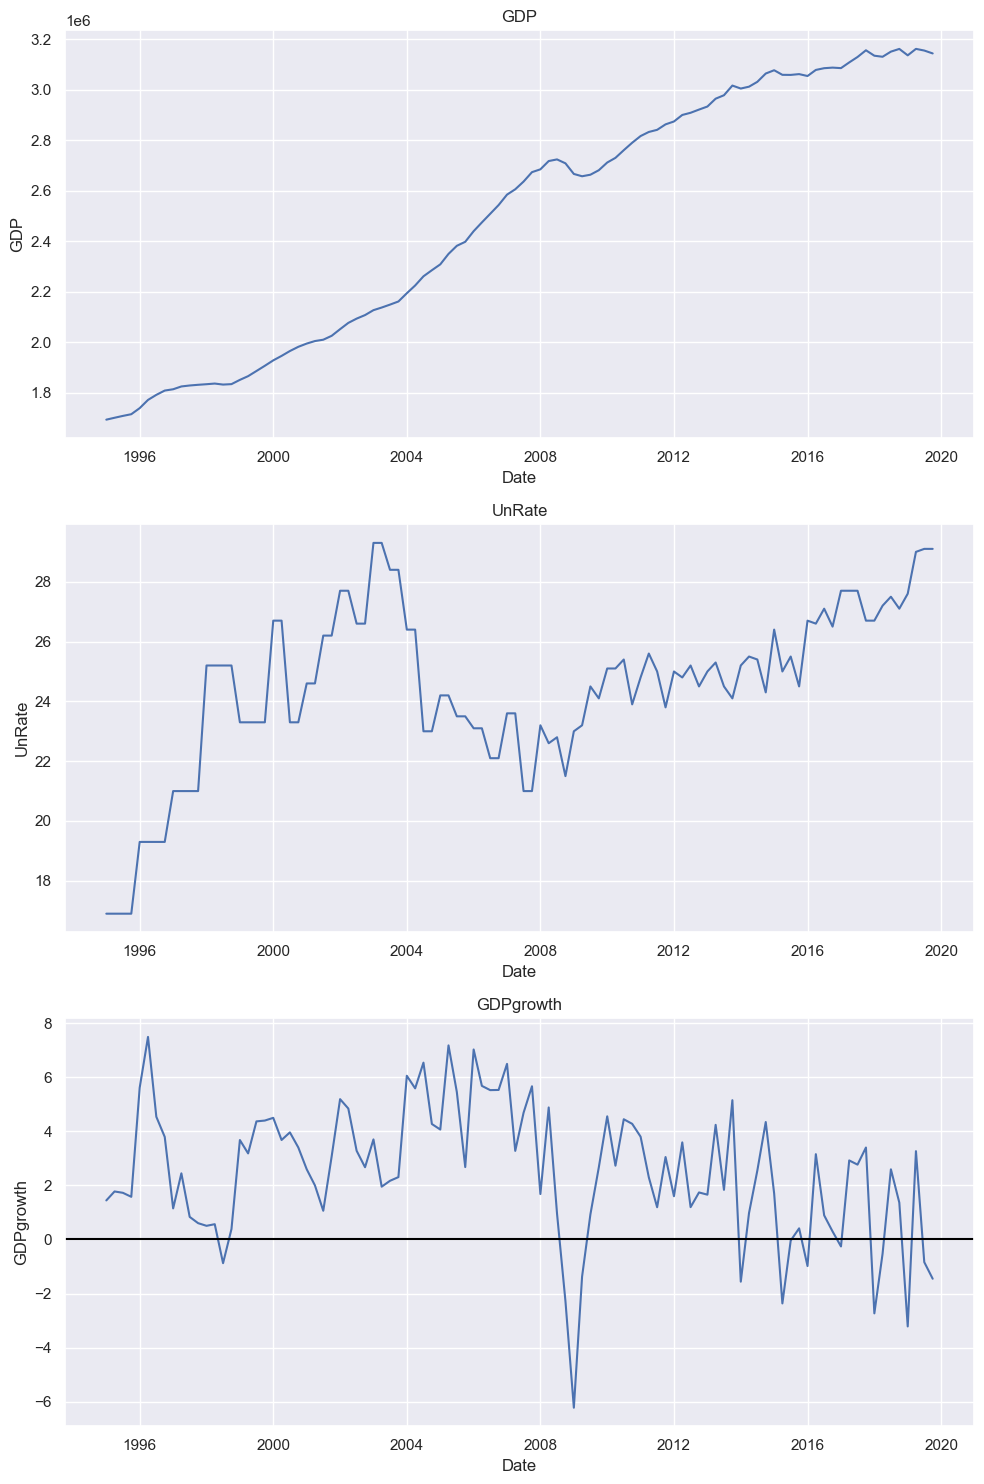

In [3]:
# Plotting the graphs for GDP, Unemployment rate and GDP growth rate
cols = ['GDP', 'UnRate', 'GDPgrowth']
fig, axes = plt.subplots(nrows=3, figsize=(10,15))

for ind, col in enumerate(cols):
    sns.lineplot(x='Date',y=col,data=df,ax=axes[ind])
    axes[ind].set_title(f'{col}')
axes[2].axhline(0,color='black')
plt.tight_layout()
sns.set()

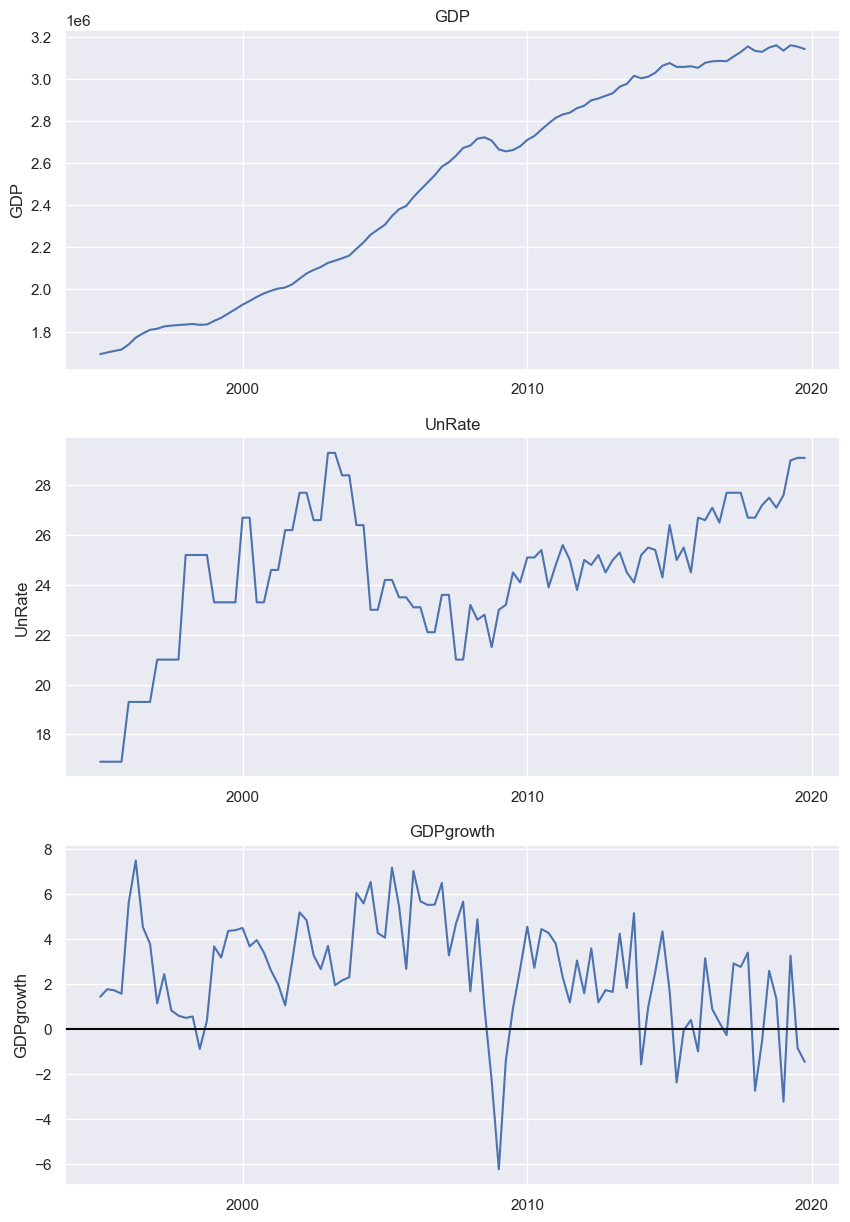

In [4]:
# Testing the new Seaborn Objects method for plotting graphs
import seaborn.objects as so

cols = ['GDP','UnRate','GDPgrowth']

fig, axes = plt.subplots(nrows=3,figsize=(10,15))

for ind, col in enumerate(cols):
    (
        so.Plot(data=df, x='Date', y=col)
        .add(so.Line())
        .on(axes[ind])
        .label(
            title=f'{col}',
            x=''
            )
        .plot()
    )
axes[2].axhline(0,color='black')

In [25]:
# Plot GDP using plotly.express
fig = px.line(
    df,
    x='Date',
    y='GDP',
    title='GDP from 1995Q1 to 2019:Q4'
)
fig.update_layout(title_x=0.5)
fig.show()

In [26]:
# Plot unemployment rate using plotly.express
fig = px.line(
    df,
    x='Date',
    y='UnRate',
    title='Unemployment rate from 1995Q1 to 2019:Q4'
    )
fig.update_layout(title_x=0.5)
fig.show()

In [27]:
# Plot GDP growth rate using plotly.express
fig = px.line(
    df,
    x='Date',
    y='GDPgrowth',
    title='GDP growth rate from 1995Q1 to 2019:Q4'
    )
fig.update_layout(title_x=0.5)
fig.add_hline(0)
fig.show()

In [9]:
# Function that takes in a timeseries and uses the Augmented Dickey-Fuller test to determine it's stationarity. 
def ADFuller_test(dframe,rvar=False,auto='AIC',reg='c',maxl=12):
    test = adfuller(x = dframe,autolag=auto,regression=reg,maxlag=maxl)
    if test[1] <= 0.05:
        sig = f'{dframe.name} is stationary'
    else:
        sig = f'{dframe.name} is nonstationary'
    results = {
        't-statistic':test[0],
        'pvalue':test[1],
        'critical values':test[4],
        'stationarity':sig

    }
    return results

In [10]:
# Log of GDP is nonstationary at level
ADFuller_test(df['LGDP'])

{'t-statistic': -2.0922375785762024,
 'pvalue': 0.2476473444374977,
 'critical values': {'1%': -3.4989097606014496,
  '5%': -2.891516256916761,
  '10%': -2.5827604414827157},
 'stationarity': 'LGDP is nonstationary'}

In [11]:
# Log of GDP is stationary at first difference
ADFuller_test(df['LGDP'].diff().dropna())

{'t-statistic': -5.275550449891832,
 'pvalue': 6.151666793699424e-06,
 'critical values': {'1%': -3.4989097606014496,
  '5%': -2.891516256916761,
  '10%': -2.5827604414827157},
 'stationarity': 'LGDP is stationary'}

In [12]:
# GDP growth rate is stationary at level
ADFuller_test(df['GDPgrowth'],reg='ct')

{'t-statistic': -5.777036845292535,
 'pvalue': 6.3778812690040294e-06,
 'critical values': {'1%': -4.053254236405479,
  '5%': -3.455806184392646,
  '10%': -3.1535907061122397},
 'stationarity': 'GDPgrowth is stationary'}

In [13]:
# Unemployment rate is nonstationary at level
ADFuller_test(df['UnRate'])

{'t-statistic': -2.075087716315337,
 'pvalue': 0.2546492079815922,
 'critical values': {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 'stationarity': 'UnRate is nonstationary'}

In [14]:
# Unemployment rate is stationary at first difference
ADFuller_test(df['UnRate'].diff().dropna())

{'t-statistic': -3.157628271508245,
 'pvalue': 0.02257210091547192,
 'critical values': {'1%': -3.506057133647011,
  '5%': -2.8946066061911946,
  '10%': -2.5844100201994697},
 'stationarity': 'UnRate is stationary'}

In [67]:
# Define dependent and independent variables
y = df['GDPgrowth']
X = df['UnRate'].diff()
X = sm.add_constant(X)

In [68]:
# Create OLS model
model = sm.OLS(y,X,missing='drop')
results = model.fit()

In [69]:
# ∆(Unrate) is negative which is expected, however since it has a p value of 0.061, the null hypothesis can be rejected and therefore
# conclude that it is not statistically significant
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              GDPgrowth   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.597
Date:                Wed, 12 Oct 2022   Prob (F-statistic):             0.0609
Time:                        15:25:45   Log-Likelihood:                -228.18
No. Observations:                  99   AIC:                             460.4
Df Residuals:                      97   BIC:                             465.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5660      0.248     10.364      0.000       2.075       3.057
UnRate        -0.3975      0.210     -1.896      0.061      -0.813       0.018
==============================================================================
Omnibus:                        6.983   Durbin-Watson:                   0.934
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                6.461
Skew:                          -0.547   Prob(JB):                       0.0395
Kurtosis:                       3.609   Cond. No.                         1.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
# Function that takes in timeseries, creates a VAR model with them, determines the correct lag length to use.
# Then it runs the Johansen cointegration test to determine if there exists any cointegrating factors between the timeseries,
# and displays how many there potentially are. 

def is_coint(dframe):
    model = VAR(dframe)
    lag = model.select_order(8).selected_orders['hqic']
    coint = vecm.coint_johansen(dframe,det_order=0,k_ar_diff=lag)
    print(f'Lag length {lag} selected\n')
    for ind, trace in enumerate(coint.trace_stat):
        if result.trace_stat_crit_vals[ind][1] > trace:
            if ind == 0:
                print('There are no coint eqs\n')
            else:
                print(f'There exists at least {ind} cointegrating equation(s)\n')
    
    print(f'Trace Statistics:\n{coint.trace_stat}\n')
    print(f'Trace Crit Values\n[0.1, 0.05 and 0.01]\n\n{coint.trace_stat_crit_vals}')

In [178]:
# Call function and display results
is_coint(df[['LGDP','UnRate']].dropna())

Lag length 2 selected

There exists at least 1 cointegrating equation(s)

Trace Statistics:
[16.38933287  3.80499753]

Trace Crit Values
[0.1, 0.05 and 0.01]

[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [227]:
# Define the VECM model
model = vecm.VECM(df[['LGDP','UnRate']],k_ar_diff=2,coint_rank=1,deterministic='co')
results = model.fit()

In [229]:
# Beta.2 * (-1) indicates that there is a long-term negative relationship between unemployment rate and GDP. 
# When the dependent variable is Unemployment Rate, L2.LGDP is negative and statistically significant. This implies that the negative effect
# that GDP has on unemplyment may not be instantaneous, and may take up to 2 quarters.
results.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
const,0.0219,0.018,1.203,0.229,-0.014,0.058
L1.LGDP,0.4931,0.103,4.800,0.000,0.292,0.694
L1.UnRate,0.0005,0.000,1.087,0.277,-0.000,0.001
L2.LGDP,0.0741,0.104,0.710,0.478,-0.130,0.279
L2.UnRate,-0.0004,0.000,-0.794,0.427,-0.001,0.001
,coef,std err,z,P>|z|,[0.025,0.975]
const,12.6756,3.804,3.332,0.001,5.220,20.131
L1.LGDP,-14.3320,21.451,-0.668,0.504,-56.375,27.711
L1.UnRate,-0.1605,0.095,-1.691,0.091,-0.346,0.025
L2.LGDP,-49.7086,21.792,-2.281,0.023,-92.420,-6.997
